In [1]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoLars, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
path_manipulate_data = os.path.abspath(os.path.join("..", "0_utils"))

sys.path.append(path_manipulate_data)

from class_manipulate_data import ManipulateData

manipulate_data = ManipulateData()
path_preprocessing_output = manipulate_data.get_path_preprocessing_output()

In [2]:
def root_mean_squared_error(y_true: pd.Series, y_pred: pd.Series) -> float:
    """Faz o cálculo do RMSE.

    Parameters
    ----------
    y_true : pd.Series
        Valor real.
    y_pred : pd.Series
        Valor predito pelo modelo.

    Returns
    -------
    float
        Valor do RMSE.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_scatter_performance_individual(y_true: np.array,
                                        y_pred: np.array,
                                        name_output: str,
                                        subtitle: str,
                                        df_metrics: pd.DataFrame = None) \
                                            -> Figure:
    """Retorna a figura do gráfico `regplot` do `seaborn` com o valor predito
    e o valor real. Além dissso, acrescenta no gráfico os dados da métrica que
    estão no `df_df_metrics`.

    Parameters
    ----------
    y_true : np.array
        Array com os valores reais.
    y_pred : np.array
        Array com os valores preditos.
    name_output : str
        Nome da feature predita.
    subtitle : str
        Legenda que será mostrada no gráfico.
    df_metrics : pd.DataFrame, optional
        DataFrame de uma única linha. Onde as colunas contém
        o nome das métricas e a linha os valores de cada uma, by default None

    Returns
    -------
    Figure
        Gráfico no formato de figura do matplotlib.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    max_value = max([y_true.max(), y_pred.max()]) + 0.05
    min_value = min([y_true.min(), y_pred.min()]) - 0.05
    identity_line = np.linspace(min_value, max_value)

    ax.plot(identity_line, identity_line, '-', color='darkgrey', linewidth=3)
    sns.regplot(x=y_true, y=y_pred,
                color='darkcyan',
                fit_reg=True,
                ax=ax,
                truncate=False)

    ax.set_ylim((min_value, max_value))
    ax.set_xlim((min_value, max_value))
    ax.set_ylabel(f'{name_output} predito', fontsize=16)
    ax.set_xlabel(f'{name_output} medido', fontsize=16)
    ax.set_title(f'Actual X Pred - {subtitle}', fontsize=18)

    if df_metrics is not None:
        test_text = df_metrics.iloc[0].to_string(float_format='{:,.2f}'.format)
        ax.text(0.1, 0.8, test_text, color='indigo',
                bbox=dict(facecolor='none', edgecolor='indigo',
                          boxstyle='round,pad=1'),
                transform=ax.transAxes, fontsize=9)

    return fig

def create_df_metrics(true: pd.Series,
                      pred: pd.Series) -> pd.DataFrame:
    """Reponsável por calcular as métricas do modelo e
    retornar um DataFrame com todas as métricas calculadas.

    Parameters
    ----------
    y_true : pd.Series
        Valor real.
    y_pred : pd.Series
        Valor predito.

    Returns
    -------
    pd.DataFrame
        DataFrame com as métricas.
    """
    metrics = {}
    metrics['MAE'] = mean_absolute_error(true, pred)
    metrics['RMSE'] = root_mean_squared_error(true, pred)
    metrics['R2'] = r2_score(true, pred)

    df_metrics = pd.DataFrame(metrics, index=['Value'])

    return df_metrics

In [3]:
equipment_name = 'FD001'
path_dataset_train = os.path.join(path_preprocessing_output, f"train_{equipment_name}.csv")

df_train = pd.read_csv(path_dataset_train)

In [4]:
path_dataset_test = os.path.join(path_preprocessing_output, f"test_{equipment_name}.csv")

df_test = pd.read_csv(path_dataset_test)

In [5]:
model = RandomForestRegressor(max_depth=8)
pipeline = Pipeline([('std', StandardScaler()), ('regressor', model)])

model = TransformedTargetRegressor(regressor=pipeline,
                                   transformer=StandardScaler())


In [6]:
df_rolling = df_train.groupby('unit_number').rolling(window=12).mean()
df_rolling = df_rolling.dropna()
df_rolling = df_rolling.reset_index()
df_train = df_rolling.drop(columns=['unit_number', 'time'])
y_train = df_train['RUL']
X_train = df_train.drop(columns=['RUL'])

In [7]:
model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('std', StandardScaler()),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=8))]),
                           transformer=StandardScaler())

In [9]:
y_train_pred = model.predict(X_train)

df_metrics_train = create_df_metrics(y_train, y_train_pred)
df_metrics_train

,MAE,RMSE,R2
Value,17.526379,25.042011,0.856898


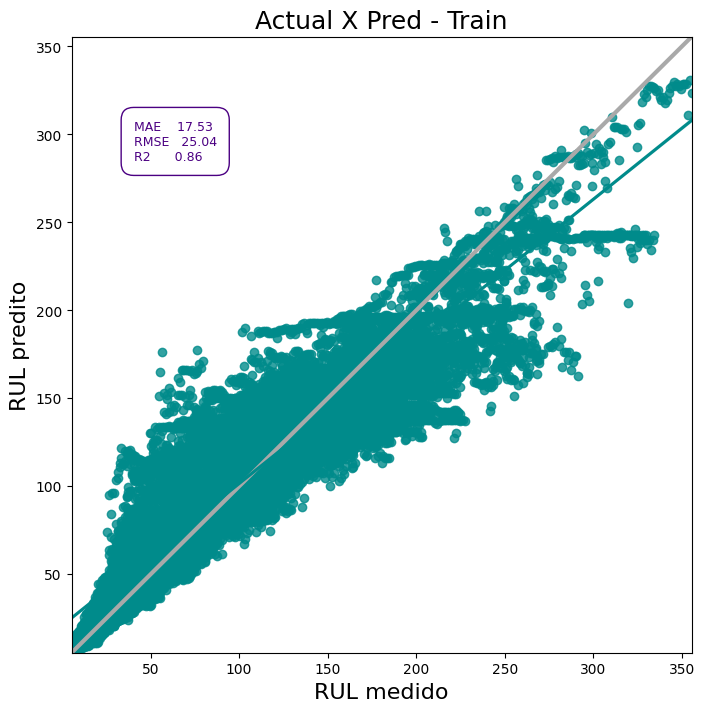

In [10]:
fig = plot_scatter_performance_individual(y_train.values, y_train_pred, 'RUL', 'Train', df_metrics_train)

In [11]:
df_rolling = df_test.groupby('unit_number').rolling(window=12).mean()
df_rolling = df_rolling.dropna()
df_rolling = df_rolling.reset_index()
df_test = df_rolling.drop(columns=['unit_number', 'time'])
y_test = df_test['RUL']
X_test = df_test.drop(columns=['RUL'])

In [12]:
y_test_pred = model.predict(X_test)
df_metrics_test = create_df_metrics(y_test, y_test_pred)
df_metrics_test

,MAE,RMSE,R2
Value,35.128278,47.899109,0.298161


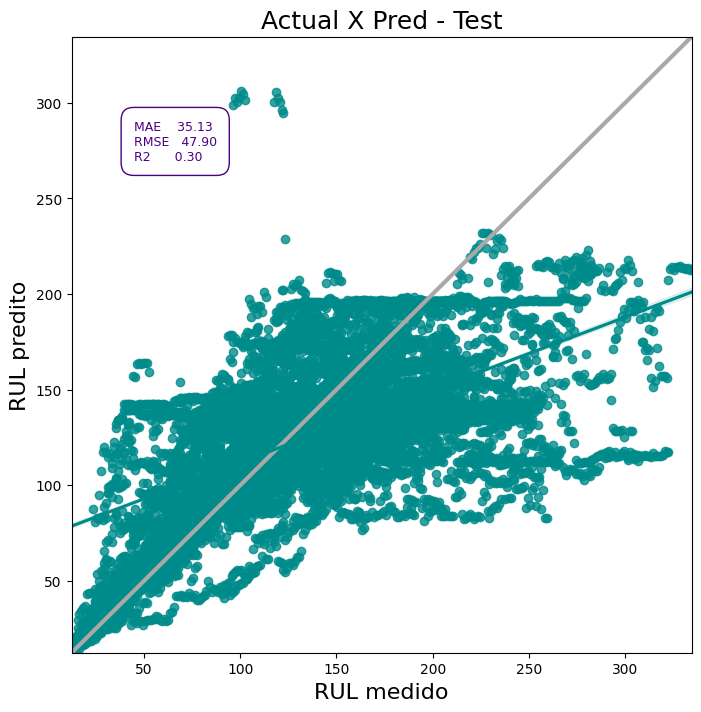

In [13]:
fig = plot_scatter_performance_individual(y_test.values, y_test_pred, 'RUL', 'Test', df_metrics_test)